<a href="https://colab.research.google.com/github/benjaminbenteke/Optimall_presentation/blob/main/XAI_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## From scratch


### Librairies importation

In [81]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import torch
from torchvision import models
import torch
from torch.utils.data  import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, datasets, models
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
import os
import numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import cv2
import torch
from PIL import Image
from torchvision import transforms
from pylab import *
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [82]:
device

device(type='cuda', index=0)

In [ ]:
## Get pretrained model: resnet
# model = models.resnet101(pretrained=True)
model = models.googlenet(pretrained=True)
model.to(device) # resnet to gpu if it is otherwise cpu
model.eval() # resnet model evaluation before any prediction

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
# !wget https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg/1200px-Cat_November_2010-1a.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg

--2022-08-26 20:12:07--  https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Cat03.jpg/1200px-Cat03.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 156145 (152K) [image/jpeg]
Saving to: ‘1200px-Cat03.jpg’

1200px-Cat03.jpg    100%[===================>] 152.49K  --.-KB/s    in 0.005s  

2022-08-26 20:12:07 (29.9 MB/s) - ‘1200px-Cat03.jpg’ saved [156145/156145]



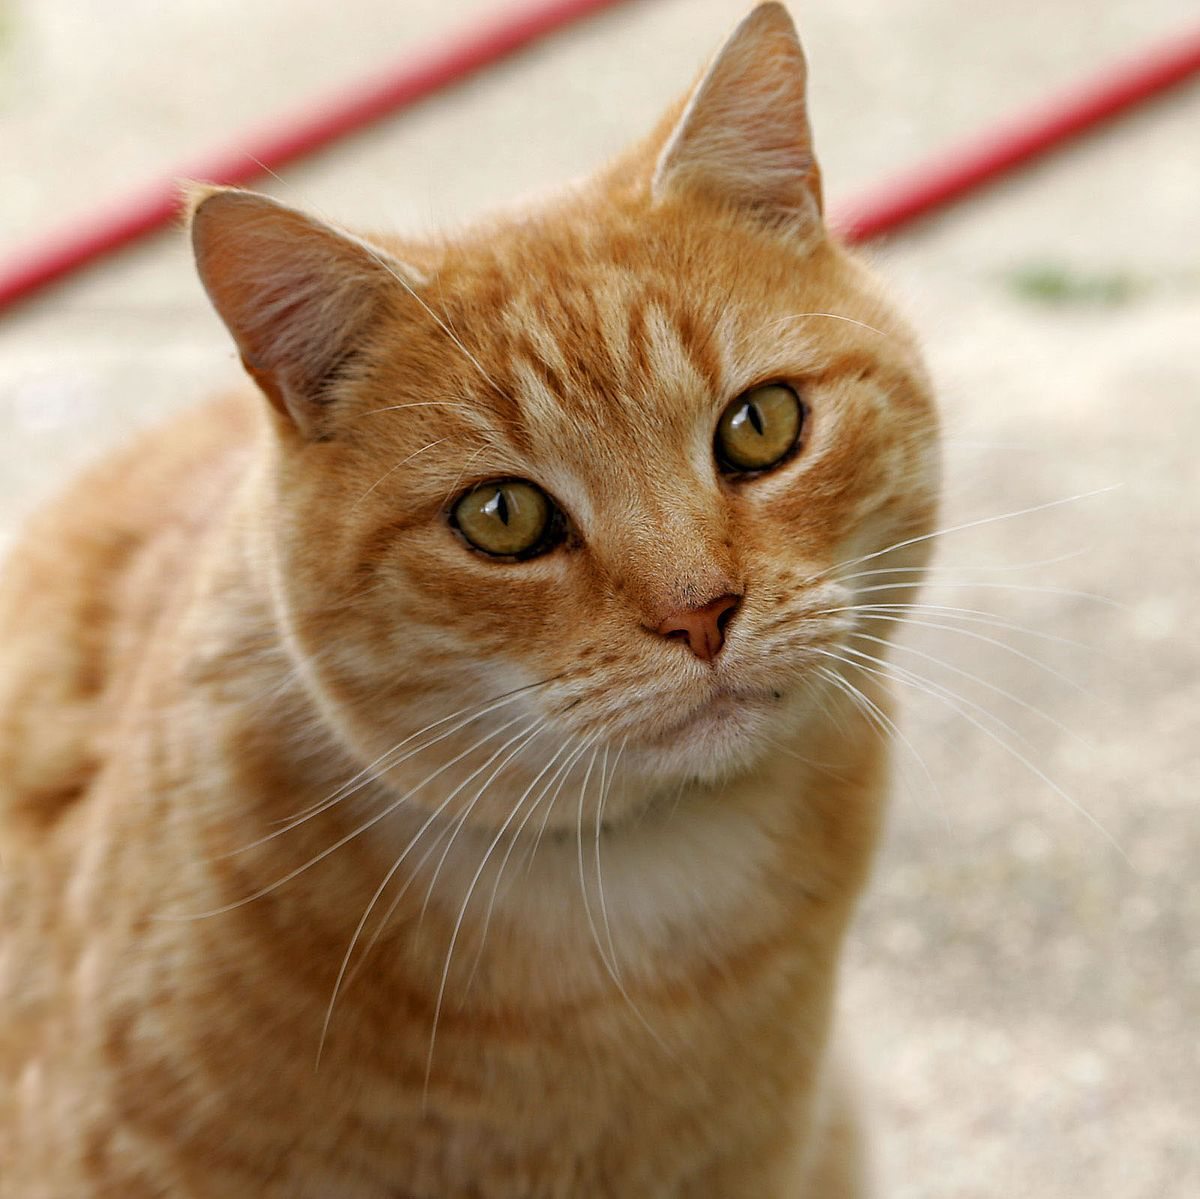

In [ ]:
## Visualize the image
im = Image.open("/content/1200px-Cat03.jpg")
im 

### use google net to predict our cat
----- We need to convert our image to a Tensor-------


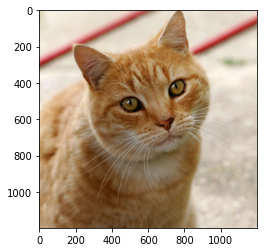

In [ ]:
img = np.asarray(im)
plt.imshow(img)
plt.show()

In [ ]:
img.shape

(1199, 1200, 3)

### Image pre-processing

In [ ]:
# model expects 224x224 3-color image: (3, 224, 224)
transform = transforms.Compose([
 transforms.Resize(224),
 transforms.CenterCrop(224),
 transforms.ToTensor()
])

# standard ImageNet normalization
transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

transformed_img = transform(im)
input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

In [ ]:
input_img.shape

torch.Size([1, 3, 224, 224])

In [ ]:
# Get classes of resnet101
import json
from torchvision.datasets.utils import download_url
# download_url("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json", ".", "imagenet_class_index.json")
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2022-08-26 20:16:38--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt.1’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-08-26 20:16:38 (97.3 MB/s) - ‘imagenet_classes.txt.1’ saved [10472/10472]



In [ ]:
with open('imagenet_classes.txt') as f:
  categories = [line.strip() for line in f.readlines()]

In [ ]:
# categories
len(categories)

1000

In [154]:
categories

['tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead',
 'electric ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house finch',
 'junco',
 'indigo bunting',
 'robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel',
 'kite',
 'bald eagle',
 'vulture',
 'great grey owl',
 'European fire salamander',
 'common newt',
 'eft',
 'spotted salamander',
 'axolotl',
 'bullfrog',
 'tree frog',
 'tailed frog',
 'loggerhead',
 'leatherback turtle',
 'mud turtle',
 'terrapin',
 'box turtle',
 'banded gecko',
 'common iguana',
 'American chameleon',
 'whiptail',
 'agama',
 'frilled lizard',
 'alligator lizard',
 'Gila monster',
 'green lizard',
 'African chameleon',
 'Komodo dragon',
 'African crocodile',
 'American alligator',
 'triceratops',
 'thunder snake',
 'ringneck snake',
 'hognose snake',
 'green snake',
 'king snake',
 'garter snake',
 'water snake',
 'vine snake',
 'night snake',
 'boa constrictor',
 'rock python',
 'Indian cobr

In [ ]:
output = model(input_img.to(device))
output = F.softmax(output, dim=1)
prediction_score, pred_label_idx = torch.topk(output, 1)
pred_label_idx.squeeze_()
predicted_label = categories[pred_label_idx.item()]
print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

Predicted: Egyptian cat ( 0.37087467312812805 )


In [ ]:
pred_label_idx

tensor(285, device='cuda:0')

In [ ]:
label_id= pred_label_idx.item()
label_id

285

### Integrated gradient methods

In [ ]:
# Generate alphas
m=30
alphas = tf.linspace(start=0.0, stop=1.0, num=m+1)

In [ ]:
# Create baseline
baseline = torch.zeros(size=(3,224,224))
baseline.shape

torch.Size([3, 224, 224])

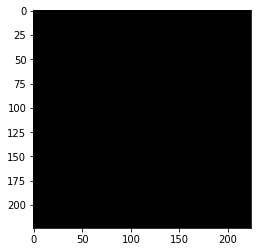

In [ ]:
figure(1)
imshow(baseline.squeeze().permute(1,2,0), interpolation='nearest')

In [ ]:
# Create interpolated images
def intepolate_img(input,baseline, alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis] # make alpha 4D: [m, 1, 1, 1]
  alphas_x= tf.make_ndarray(tf.make_tensor_proto(alphas_x))
  alphas_x= torch.tensor(alphas_x)

  baseline_x= torch.unsqueeze(baseline, 0) # Baseline was [3, 224, 224]
  x_x_prime = input - baseline_x

  images = baseline_x + alphas_x*x_x_prime

  return images

In [ ]:
interpolated_images= intepolate_img(input=input_img, baseline=baseline,alphas=alphas) # This the path (all 51 images from baseline to the original image, include the baseline)

In [ ]:
interpolated_images.shape

torch.Size([31, 3, 224, 224])

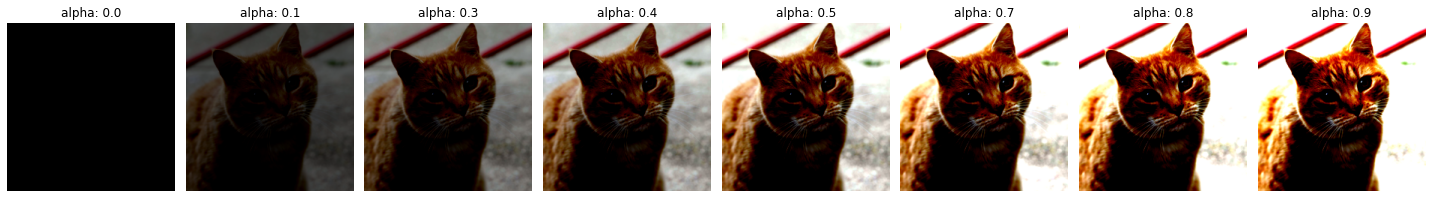

In [ ]:
step= 4
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::step], interpolated_images[0::step]):
  i += 1
  plt.subplot(1, len(alphas[0::step]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image.squeeze().permute(1,2,0))
  plt.axis('off')

plt.tight_layout()

In [ ]:
# Prediction and Gradient 
def output_and_gradient_computation(inputs, model, target_label_idx, cuda=False):
  
    gradients = []

    for input in inputs:

      # input= np.transpose(input, (2,0,1))
      # print(input.shape)
      input= torch.tensor(input,dtype=torch.float)
      input= input.unsqueeze(0)
      input.requires_grad = True
      output = model(input.to(device))
      output = F.softmax(output, dim=1)


      if target_label_idx is None:
          target_label_idx = torch.argmax(output, 1).item()
      index = np.ones((output.size()[0], 1)) * target_label_idx
      index = torch.tensor(index, dtype=torch.int64)
      index= torch.tensor(index).to(device)
      if cuda:
          index = index.cuda()
      output = output.gather(1, index)

      model.zero_grad()
      output.backward()

      gradient = input.grad.detach().cpu().numpy()[0]
      gradients.append(gradient)
    gradients = np.array(gradients)
    return gradients, output, target_label_idx

In [ ]:
grad, output, _= output_and_gradient_computation(interpolated_images, model, label_id, False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
output, grad.shape

(tensor([[0.3709]], device='cuda:0', grad_fn=<GatherBackward0>),
 (31, 3, 224, 224))

In [ ]:
baseline.shape, input_img.shape

(torch.Size([3, 224, 224]), torch.Size([1, 3, 224, 224]))

In [ ]:
baseline= torch.unsqueeze(baseline, 0)

In [ ]:
baseline.shape

torch.Size([1, 3, 224, 224])

In [ ]:
grad.shape

(31, 3, 224, 224)

In [ ]:
# input_img-baseline

In [139]:
## Integrated gradient implementation

def integrated_gradients(inputs, model, target_label_idx, grad, baseline, steps=50, cuda=False):
  if baseline is None:
        baseline = 0 * inputs 

  avg_grads = np.average(grad[:-1], axis=0)
  delta_X = inputs-baseline
  integrated_grad = delta_X * avg_grads

  return integrated_grad.squeeze(0)

In [ ]:
ig= integrated_gradients(input_img, model, label_id, grad, baseline, 50, False)
ig.shape

torch.Size([3, 224, 224])

In [104]:
## Visualizations
def plot_img_attributions(baseline, image, target_class_idx, ig, m_steps=50, cmap=None, overlay_alpha=0.4):

  attribution_mask = tf.reduce_sum(tf.math.abs(ig), axis=0)
  # print(attribution_mask.shape)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  # axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline.squeeze().permute(1,2,0))
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')
  axs[0, 1].set(title = f"predicted:{categories[target_class_idx]}")

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')


  plt.tight_layout()
  return fig

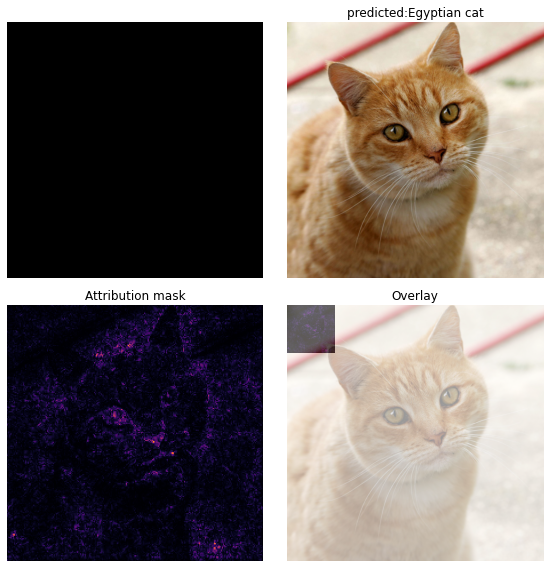

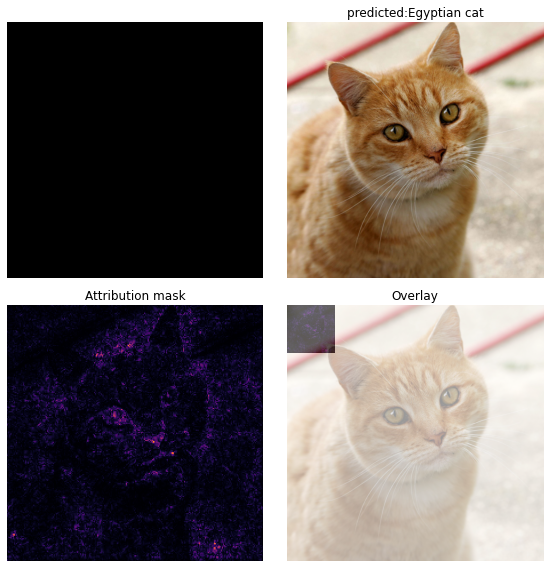

In [105]:
plot_img_attributions(baseline, im, label_id,ig, m_steps=m, cmap=plt.cm.inferno, overlay_alpha=0.4)

# using Captum

In [ ]:
# !pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
import matplotlib

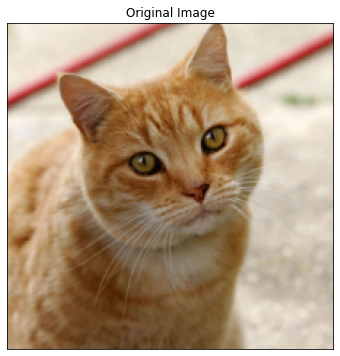

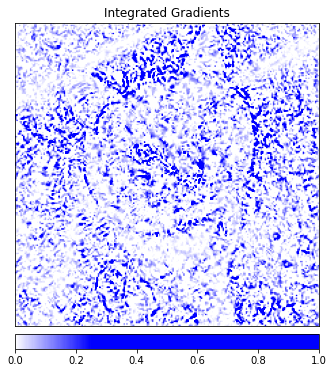

In [ ]:
# Initialize the attribution algorithm with the model
integrated_gradients = IntegratedGradients(model)

# Ask the algorithm to attribute our output target to 
attributions_ig = integrated_gradients.attribute(input_img.to(device), target=pred_label_idx, n_steps=200)

# Show the original image for comparison
_ = viz.visualize_image_attr(None, np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)), 
                      method="original_image", title="Original Image")

default_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom blue', 
                                                 [(0, '#ffffff'),
                                                  (0.25, '#0000ff'),
                                                  (1, '#0000ff')], N=256)

_ = viz.visualize_image_attr(np.transpose(attributions_ig.squeeze().cpu().detach().numpy(), (1,2,0)),
                             np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                             method='heat_map',
                             cmap=default_cmap,
                             show_colorbar=True,
                             sign='positive',
                             title='Integrated Gradients')

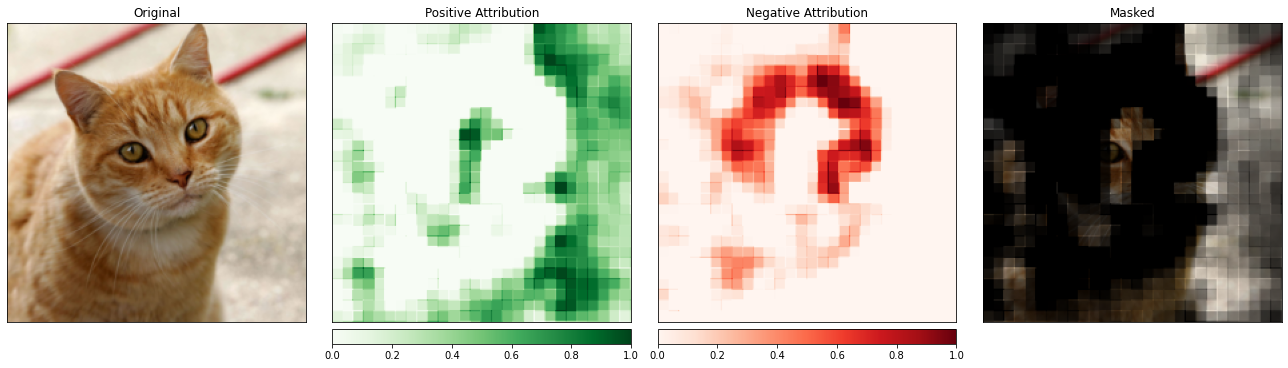

In [ ]:
occlusion = Occlusion(model)

attributions_occ = occlusion.attribute(input_img.to(device),
                                       target=pred_label_idx,
                                       strides=(3, 8, 8),
                                       sliding_window_shapes=(3,15, 15),
                                       baselines=0)


_ = viz.visualize_image_attr_multiple(np.transpose(attributions_occ.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      ["original_image", "heat_map", "heat_map", "masked_image"],
                                      ["all", "positive", "negative", "positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Negative Attribution", "Masked"],
                                      fig_size=(18, 6)
                                     )

In [ ]:
## Generalize IG
## Load an image from local

## Customize

In [106]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())[0]

In [168]:
path_lt= upload_files()

Saving dog.jpeg to dog.jpeg


In [109]:
# Image.open(path_lt)

In [156]:
## Open image
def open_image(path):
  return Image.open(path)

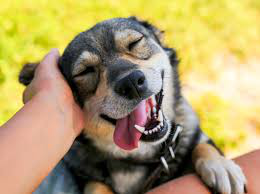

In [169]:
im= open_image(path_lt)
im

In [170]:
def transf(im):
  # model expects 224x224 3-color image: (3, 224, 224)
  transform = transforms.Compose([
  transforms.Resize(224),
  transforms.CenterCrop(224),
  transforms.ToTensor()
  ])

  # standard ImageNet normalization
  transform_normalize = transforms.Normalize(
      mean=[0.485, 0.456, 0.406],
      std=[0.229, 0.224, 0.225]
  )

  transformed_img = transform(im)
  input_img = transform_normalize(transformed_img)
  input_img = input_img.unsqueeze(0) # the model requires a dummy batch dimension

  return input_img

In [171]:
input_img= transf(im)

In [172]:
input_img.shape

torch.Size([1, 3, 224, 224])

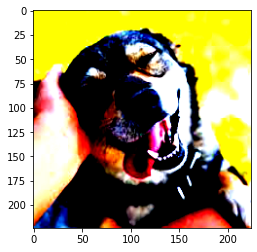

In [173]:
plt.imshow(input_img.squeeze().permute((1,2,0)))

In [174]:
def predict(model, input_img, categories):
  output = model(input_img.to(device))
  output = F.softmax(output, dim=1)
  prediction_score, pred_label_idx = torch.topk(output, 1)
  pred_label_idx.squeeze_()
  predicted_label = categories[pred_label_idx.item()]
  print('Predicted:', predicted_label, '(', prediction_score.squeeze().item(), ')')

  return predicted_label, pred_label_idx.item()

In [175]:
def explain_image(model, input_img, baseline, alphas):

  predicted_label, label_id= predict(model, input_img, categories)
  
  interpolated_images= interpolated_images= intepolate_img(input=input_img, baseline=baseline,alphas=alphas)
  if len(interpolated_images.shape) != 4:
    interpolated_images= interpolated_images.squeeze(0)

  grad, output, _= output_and_gradient_computation(interpolated_images, model, label_id, False)

  ig= integrated_gradients(input_img, model, label_id, grad, baseline, m, False)

  plot_img_attributions(baseline, im, label_id,ig, m_steps=m, cmap=plt.cm.inferno, overlay_alpha=0.4)

Predicted: Norwegian elkhound ( 0.5000064373016357 )


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


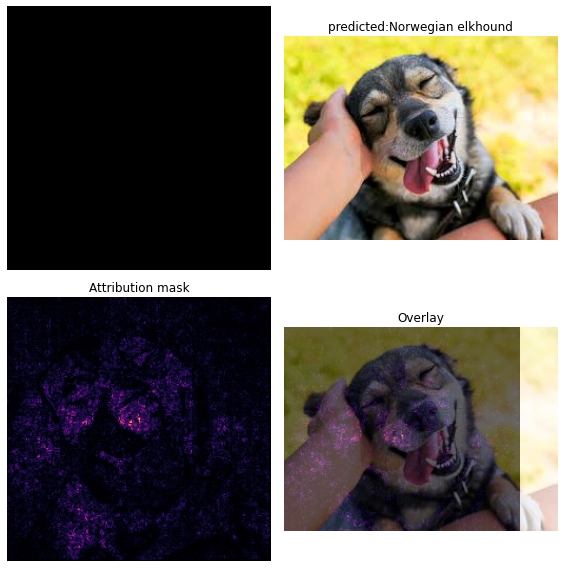

In [176]:
explain_image(model, input_img, baseline, alphas)